#配对交易（Paris Trading）
这个Notebook包括了一个配对交易策略的实现过程，目前传统配对寻找方法（如基于历史价格相关性的简单策略）已经被广泛使用，利润空间小，难以在竞争激烈的市场中获得超额收益，因此**配对的选择成为配对交易策略成败的关键**。

---

我通过参考《Enhancing a Pairs Trading strategy with the application of Machine Learning》（发表于《Expert Systems with Applications》 JCR1区期刊）的部分方法和经验，结合机器学习的**无监督算法**和**统计分析**来优化配对的寻找方式。不仅提高了配对选择的有效性还拓宽了传统策略的局限性（如仅在相同板块寻找配对），从而使得本策略在高竞争环境中有更大的利润潜力。

具体来说，这个notebook可以分为两个大的模块：
* 寻找和选择配对
* 对配对进行交易回测


其中，寻找配对部分包括以下几个关键的步骤：
1. 使用**PCA降维**从而减少股票价格的噪音影响
2. **OPTICS聚类**，使用OPTICS的主要优势在于：不限制聚类个数、不局限于板块、可以处理异常值、不局限于聚类的形状。
3. 通过**平稳性检验、Hurst检验、协整检验、控制半衰期**等方式来筛选合适的配对。

具体实现方式如下：




In [ ]:
pip install vectorbt

In [ ]:
pip install -U kaleido

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import sys
#import pandas_ta as ta

In [2]:
import vectorbt as vbt

##数据载入和清洗
选择**标普500（S&P500）和纳斯达克100（Nasdaq100）**指数中包含的股票作为分析对象。

**时间区间**为：2024-08-15至2024-10-01 （15分钟级别数据）

选择这两个市场的原因是：
1. 他们分别代表了**不同领域**的公司，标普500涵盖了传统行业和制造业，纳斯达克有很多科技股，这种分布差异为交易提供了潜在的对冲机会。比如疫情初期全球供应链断裂，传统行业影响影响严重，但是科技股相对影响较小。通过在这两个市场寻找配对，可以构建更稳健的交易策略。
2. 这两个指数中的股票可以确保一定的**流动性**，一定程度上避免交易导致的市场影响或者滑点导致的损失。

In [3]:
#使用标普500和纳斯达克100，共600支股票
url_sp500='https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
url_ns100='https://en.wikipedia.org/wiki/Nasdaq-100'
sp500=pd.read_html(url_sp500)[0]
ns100=pd.read_html(url_ns100)[4]

In [4]:
#数据清洗，得到tickers
ticker=pd.concat([(sp500[['Symbol','GICS Sector']].rename(columns={'Symbol':'Ticker'})),ns100[['Ticker','GICS Sector']]])
ticker=ticker.reset_index(drop=True)

In [5]:
#去重
ticker=ticker.drop_duplicates(subset=['Ticker']).reset_index(drop=True)

In [6]:
#按行业分类的股票数
ticker['GICS Sector'].value_counts()

,count
GICS Sector,
Industrials,78
Information Technology,78
Financials,72
Health Care,64
Consumer Discretionary,53
Consumer Staples,39
Utilities,31
Real Estate,31
Materials,28


In [7]:
print(ticker['Ticker'].nunique())
print(ticker.shape)

519
(519, 2)


In [8]:
#加载数据
ticker_input=list(ticker['Ticker'])
#加载日15分钟收盘价数据
#data_raw=yf.download(ticker_input,start='2018-01-01',end='2024-10-01',interval='1d').get('Adj Close')
data_raw=yf.download(ticker_input,start='2024-08-15',end='2024-10-01',interval='15m').get('Adj Close')

[*********************100%***********************]  519 of 519 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; no price data found  (15m 2024-08-15 -> 2024-10-01)')


In [9]:
#（跳过）交易量筛选，保证每只股票每天都有交易，全都满足（跳过）
#data=yf.download(ticker_input,period='1y',interval='1d').get('Volume')

In [10]:
#筛选缺失值
miss=data_raw.isnull().sum()
miss_list=miss[miss>0].index.tolist()
data_raw.drop(columns=miss_list,inplace=True)

In [11]:
data_raw.shape

(832, 471)

##配对选择
这个部分主要的流程为：
* 标准化回报率
* 使用PCA降维
  * 为了确定主成分的数量进行了多次尝试，主成分数量太多会导致过拟合和维度诅咒，进而增加算力消耗，同时也会包括更多噪音。
* OPTICS进行聚类
* 可视化聚类结果


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
#分割数据集
df_prices_train,df_prices_test=train_test_split(data_raw,test_size=0.1,random_state=44,shuffle=False)

In [14]:
#计算日回报率
data=df_prices_train.pct_change().dropna()

In [15]:
print('共有潜在的组合数为：',len(data.columns)*(len(data.columns)-1)/2)

共有潜在的组合数为： 110685.0


In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [17]:
#标准化回报率
norm=StandardScaler()
norm_data=norm.fit_transform(data)

In [18]:
#PCA降维
def apply_PCA(components,df,svd_solver='auto',random_state=44):
  if not isinstance(components,str):
    if components>df.shape[0]:
      print('ERROR:主成分数量大于样本')
      exit()
  pca=PCA(n_components=components,svd_solver=svd_solver,random_state=random_state)
  pca.fit(norm_data)
  explained_variance=pca.explained_variance_
  return pca.components_.T,explained_variance

In [19]:
#设置comp=6
X,explained_variance=apply_PCA(6,norm_data)

In [20]:
X.shape

(471, 6)

In [21]:
explained_variance

array([113.67234354,  46.18198267,  18.12652537,  14.03650351,
         9.65915318,   8.89739687])

In [22]:
from sklearn.cluster import OPTICS

In [23]:
#OPTICS聚类
def apply_OPTICS(x,df,min_samples,max_eps=2,xi=0.05,cluster_method='xi'):
  clf=OPTICS(min_samples=min_samples,max_eps=max_eps,xi=xi,metric='euclidean',cluster_method=cluster_method)
  print(clf)
  clf.fit(X)
  labels=clf.labels_
  n_clusters_=len(set(labels))-(1 if -1 in labels else 0)
  print(f'clusters discovered:{n_clusters_}')
  clustered_series_all=pd.Series(index=df.columns,data=labels.flatten())
  clustered_series=clustered_series_all[clustered_series_all!=-1]
  counts=clustered_series.value_counts()
  print(f'Pairs to evaluate:{(counts*(counts-1)/2).sum()}')
  return clustered_series_all,clustered_series,counts,clf

In [24]:
#聚类结果
clustered_series_all,clustered_series,counts,clf=apply_OPTICS(X,data,6)

OPTICS(max_eps=2, metric='euclidean', min_samples=6)
clusters discovered:13
Pairs to evaluate:825.0


###可视化聚类结果
* 图1：每个聚类中的股票数量
* 图2：使用t-SNE来展示聚类结果，每个颜色表示一个聚类，每个圆点表示一只股票，灰色点表示未被选中的股票
* 图3：每个聚类中股票的股价走势，可以看到同一个聚类中，股价走势相似

In [25]:
#可视化每个聚类中的股票数量
import matplotlib.pyplot as plt
import matplotlib.cm as cm
def plot_cluster_size(counts):
  plt.figure(figsize=(8,6))
  plt.barh(counts.index+1,counts.values)
  plt.yticks(np.arange(1,len(counts)+1,1))
  plt.xlabel('tickers within cluster',size=12)
  plt.ylabel('Cluster ID',size=12)

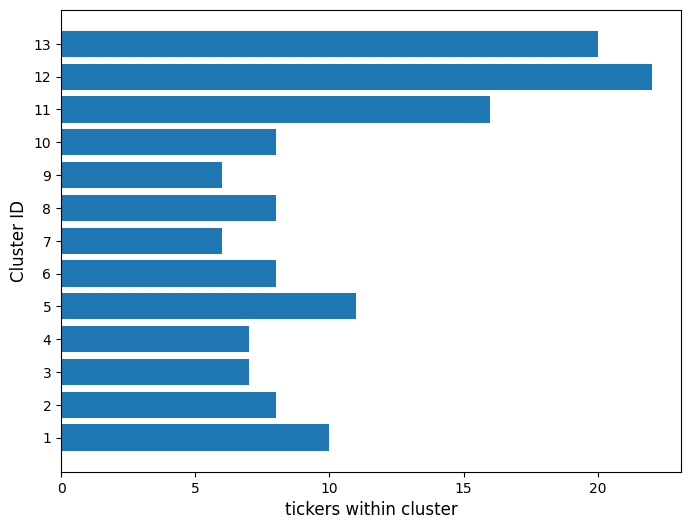

In [26]:
plot_cluster_size(counts)

In [27]:
#使用t-SNE可视化聚类结果
from sklearn.manifold import TSNE
def plot_t_SNE(X,clf,clustered_series_all):
  X_tsne=TSNE(learning_rate=1000,perplexity=25,random_state=44).fit_transform(X)
  fig=plt.figure(1,facecolor='white',figsize=(10,10),frameon=True,edgecolor='black')
  plt.clf()

  ax=fig.add_subplot(1,1,1,alpha=0.9)
  ax.spines['left'].set_position('center')
  ax.spines['left'].set_alpha(0.3)
  ax.spines['bottom'].set_position('center')
  ax.spines['bottom'].set_alpha(0.3)
  ax.spines['right'].set_color('none')
  ax.spines['top'].set_color('none')

  ax.xaxis.set_ticks_position('bottom')
  ax.yaxis.set_ticks_position('left')
  ax.tick_params(which='major',labelsize=8)

  labels=clf.labels_
  x=X_tsne[(labels!=-1),0]
  y=X_tsne[(labels!=-1),1]
  tickers=list(clustered_series_all[clustered_series_all!=-1].index)
  plt.scatter(x,y,s=300,alpha=0.75,c=labels[labels!=-1],cmap=cm.Paired)
  for i,ticker in enumerate(tickers):
    plt.annotate(ticker,(x[i]-2,y[i]+1),size=8)
  x=X_tsne[(clustered_series_all==-1).values,0]
  y=X_tsne[(clustered_series_all==-1).values,-1]
  tickers=list(clustered_series_all[clustered_series_all==-1].index)

  plt.scatter(x,y,s=150,alpha=0.2,c='black')
  #plt.xlabel('t-SNE Dim. 1',position=(0.92,0),size=10)
  #plt.ylabel('t-SNE Dim. 2',position=(0,0.92),size=10)
  #ax.set_xticks(range(-300,301,600))
  #ax.set_yticks(range(-300,301,600))
  plt.show()



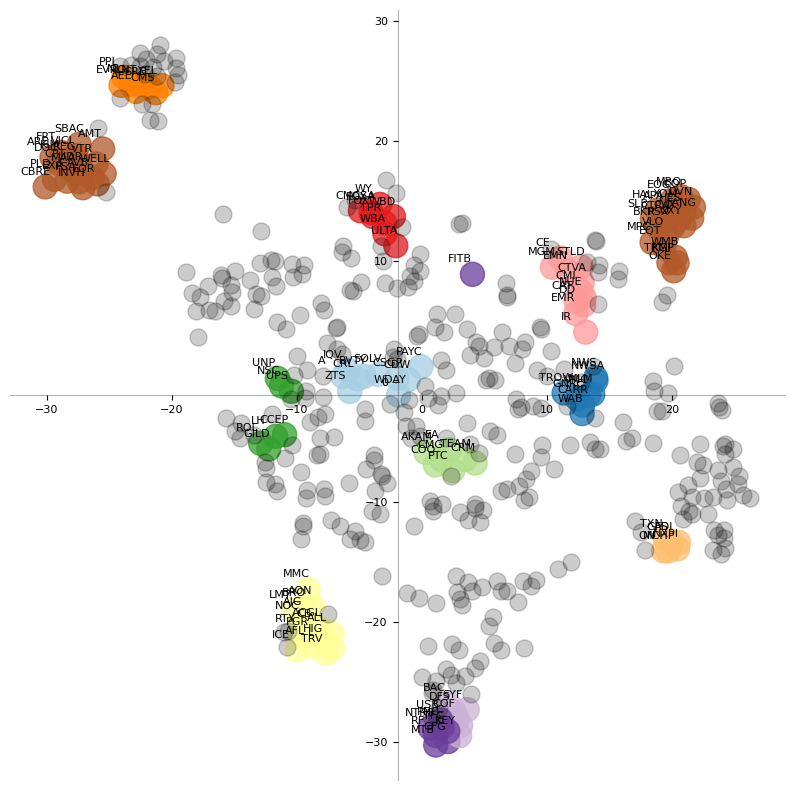

In [28]:
plot_t_SNE(X,clf,clustered_series_all)

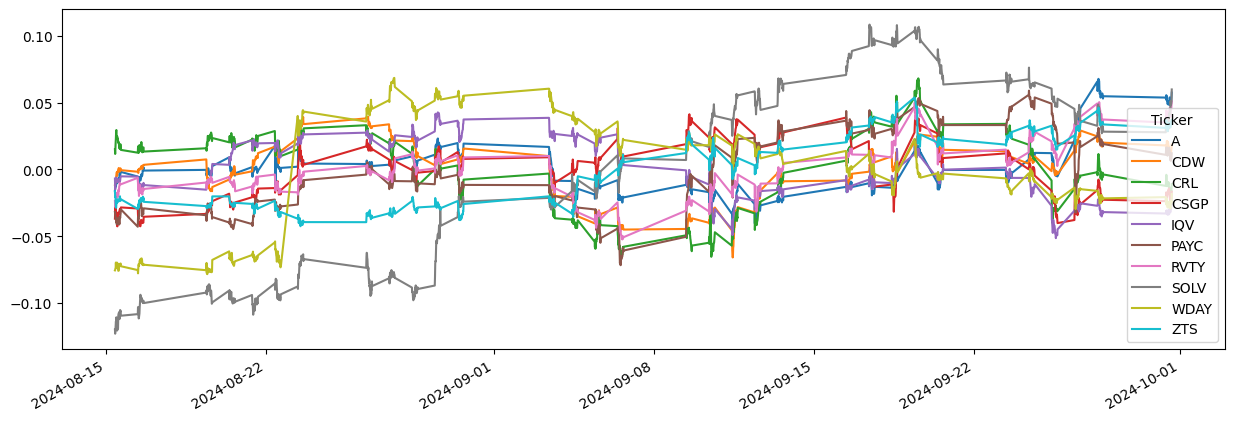

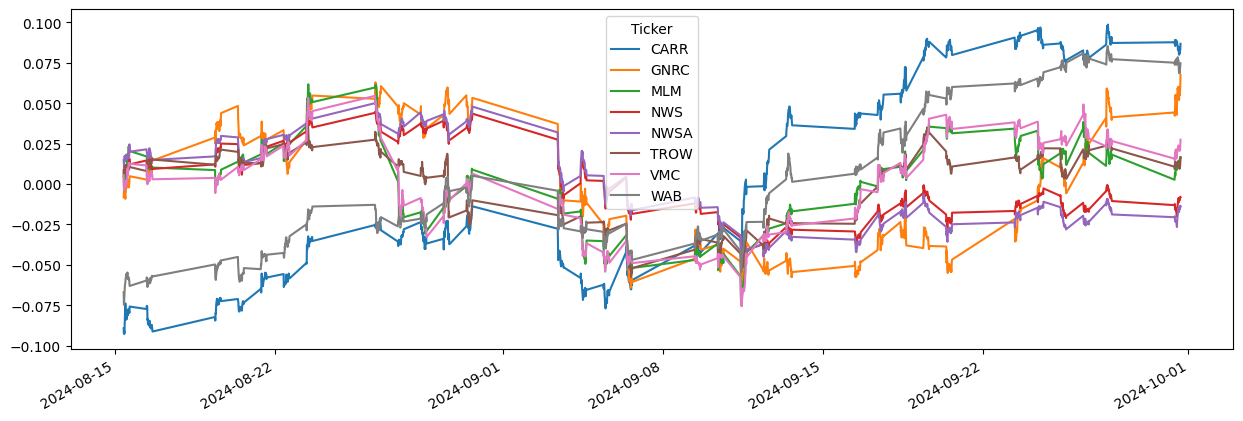

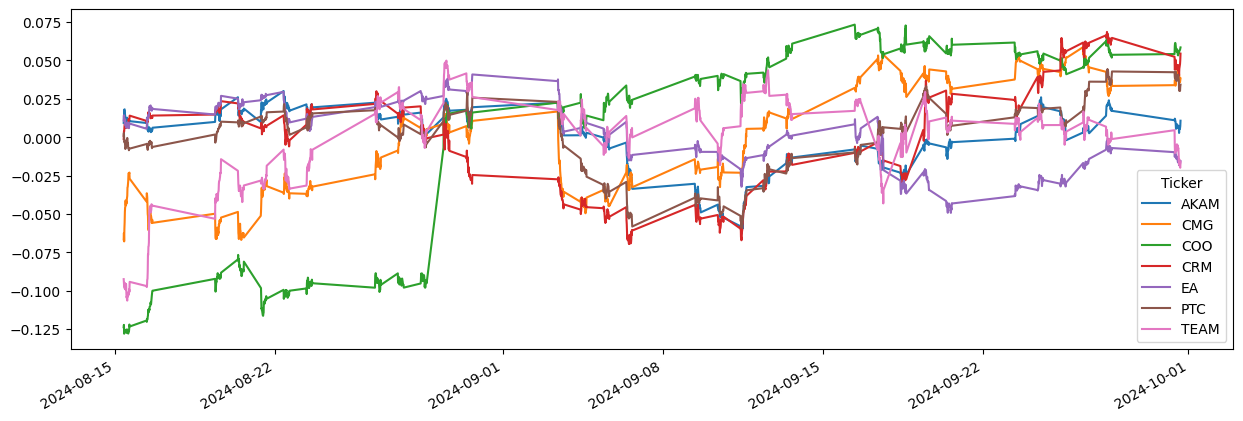

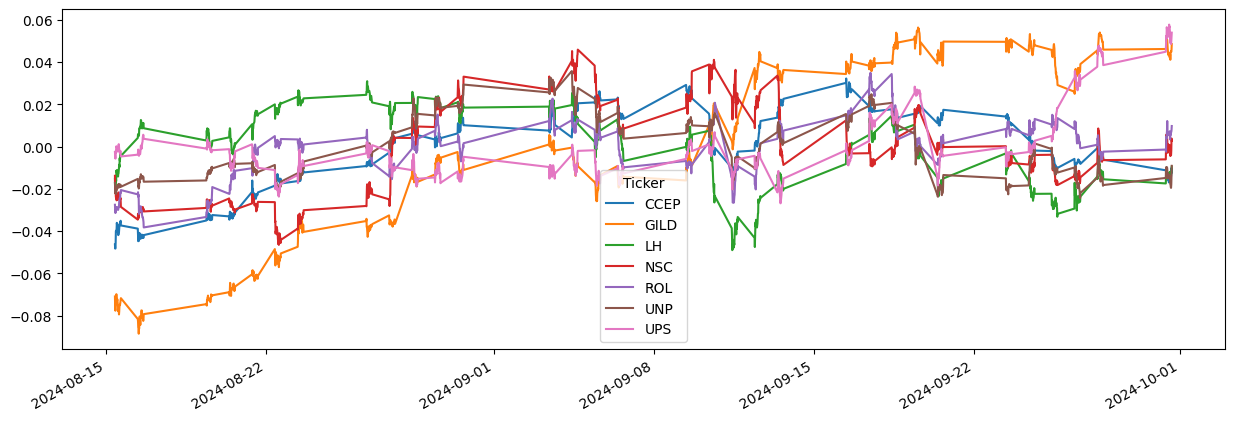

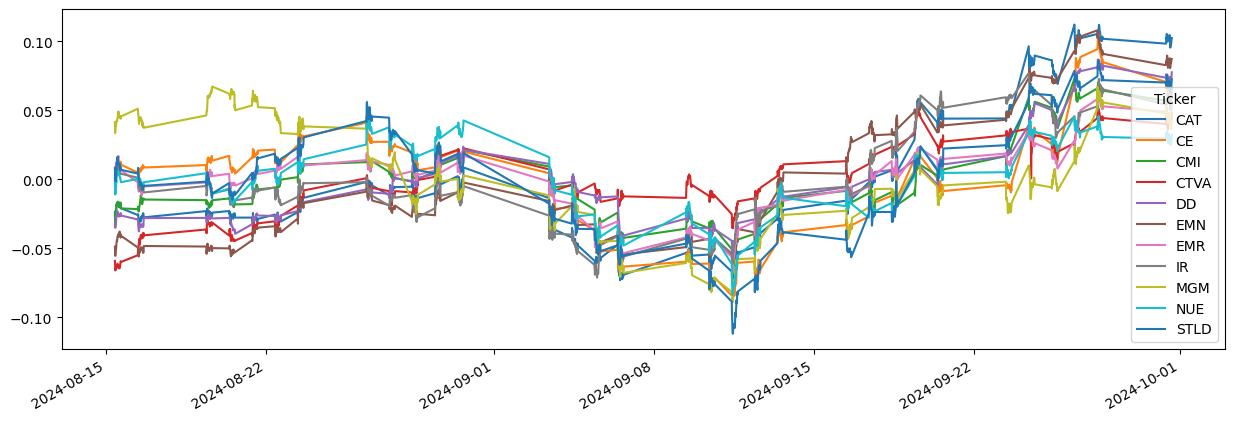

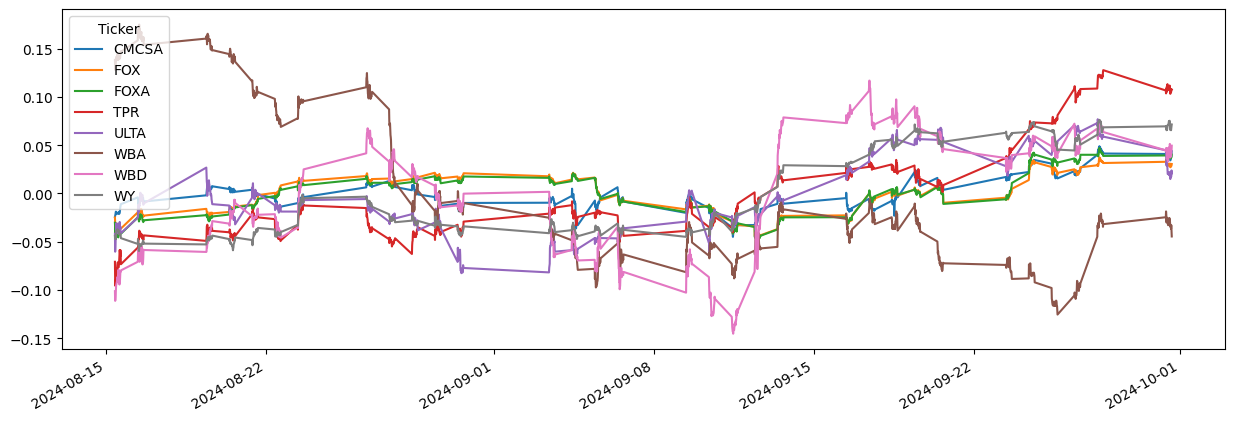

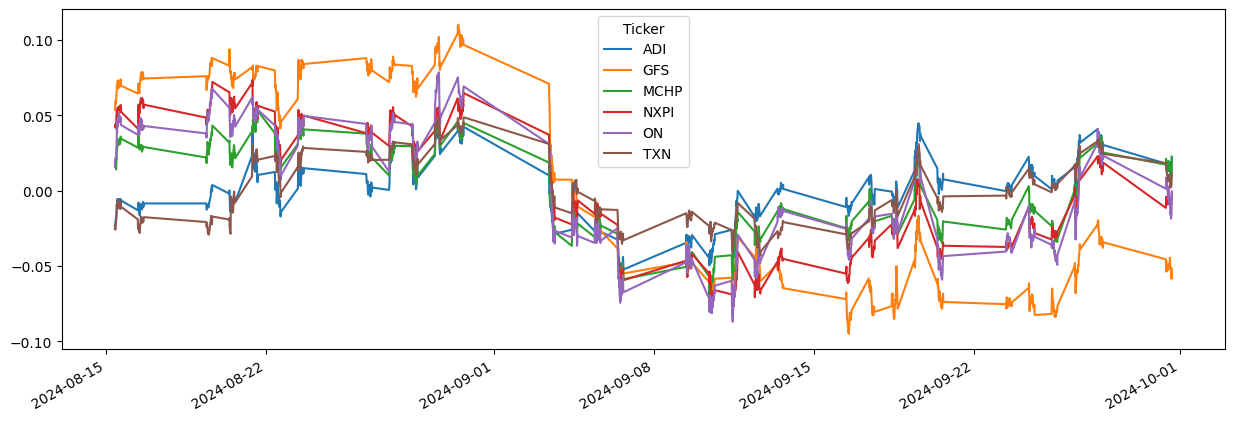

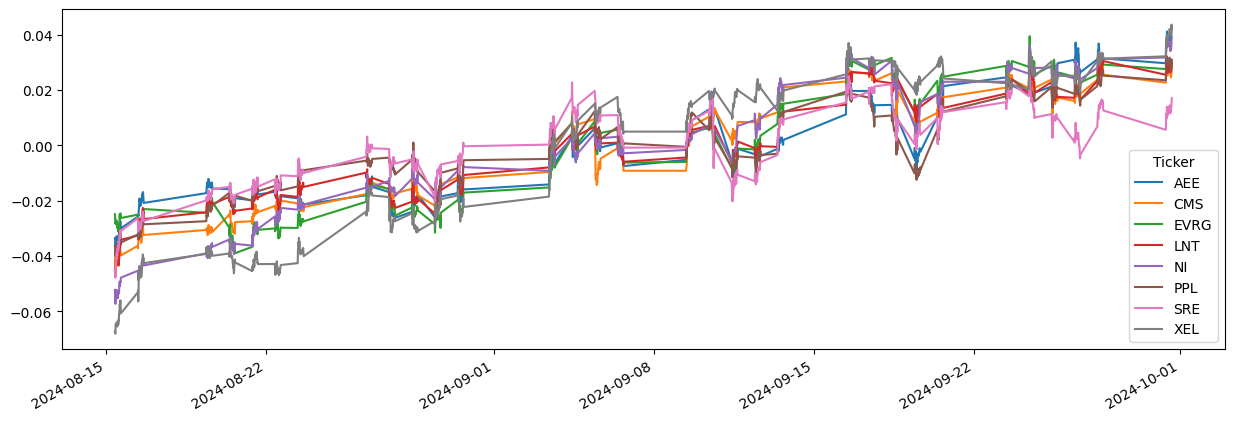

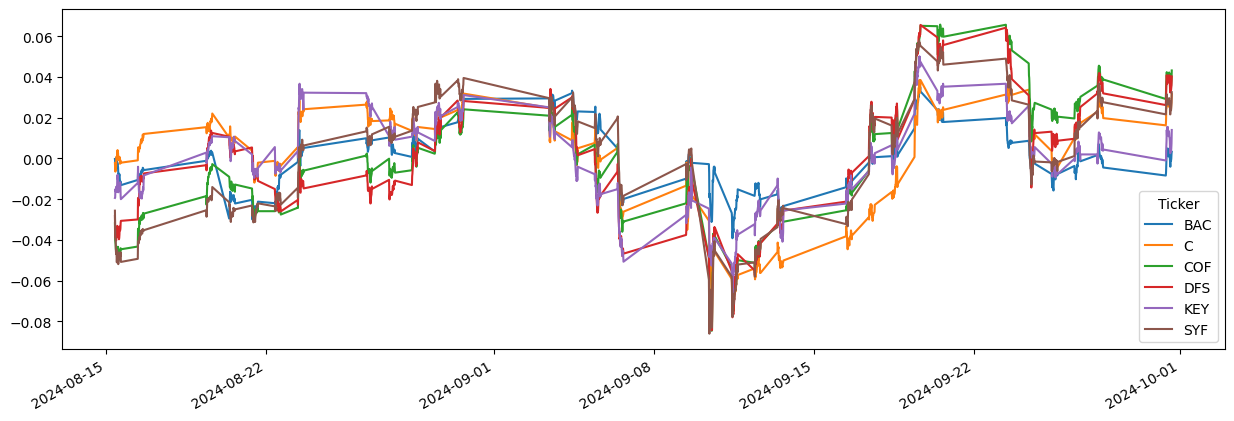

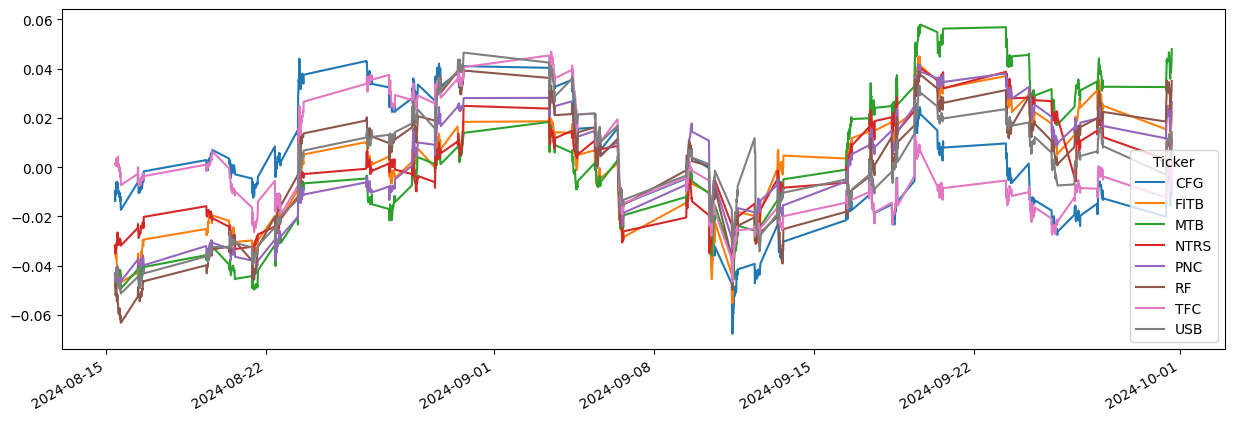

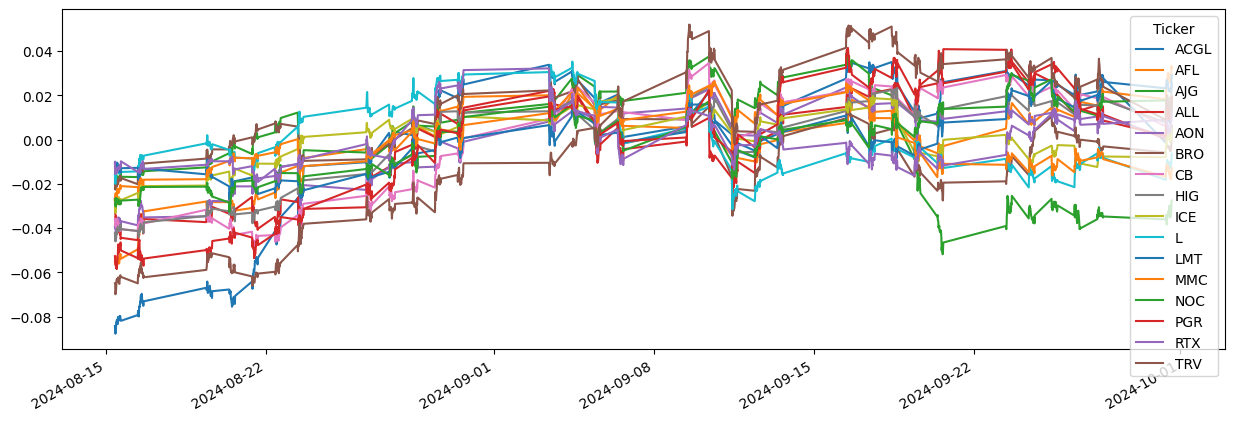

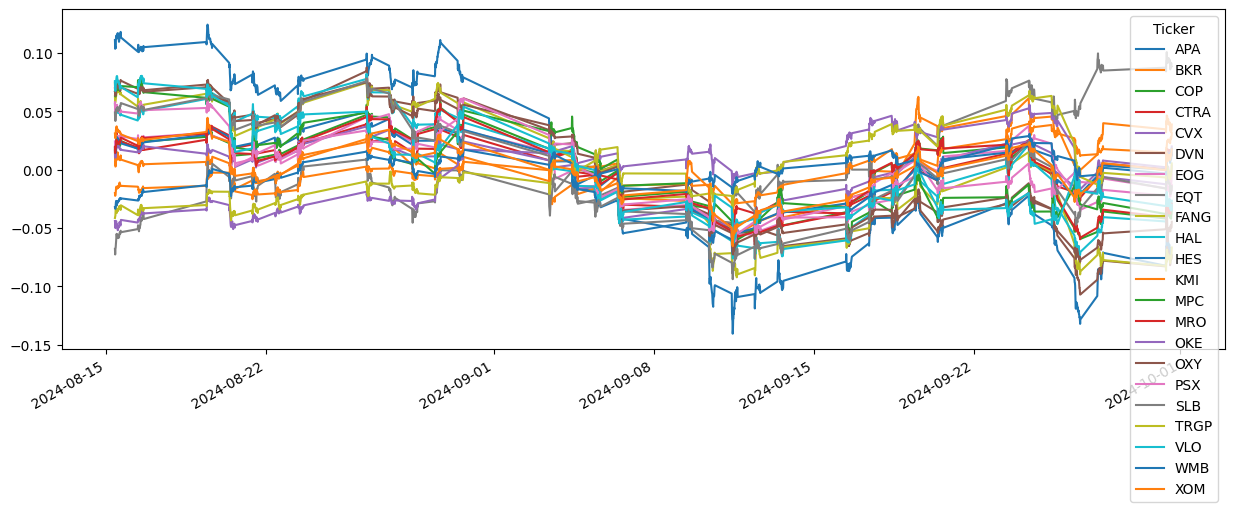

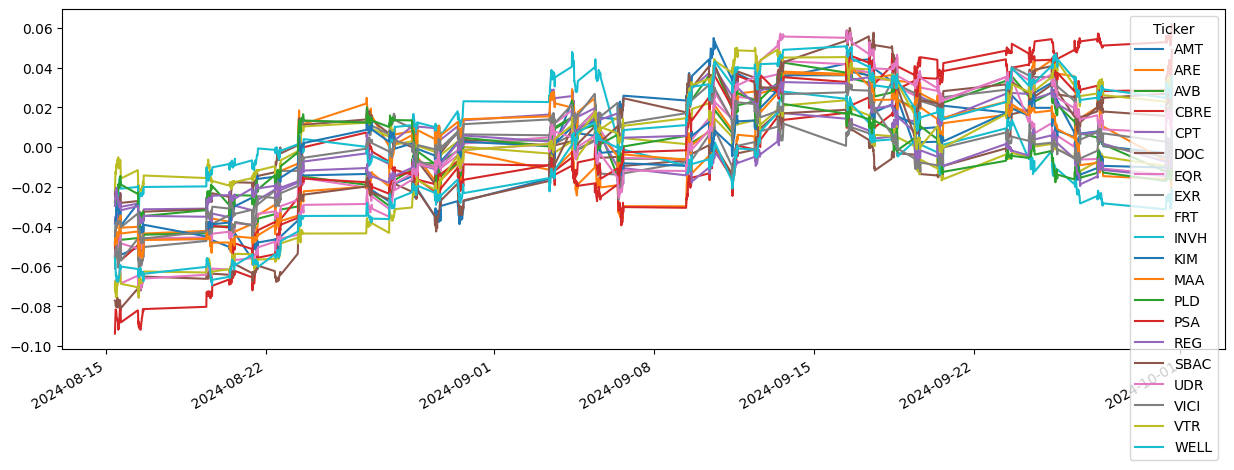

In [33]:
#每个聚类的股价走势
for clust in range(len(counts)):
  symbols=list(clustered_series[clustered_series==clust].index)
  means=np.log(data_raw[symbols].mean())
  series=np.log(data_raw[symbols]).sub(means)
  series.plot(figsize=(15,5))
  plt.show()

##配对筛选
可以看到一共得到了**13个聚类，825个潜在的配对**，现在对这些配对进行筛选。

具体流程包括：
1. **平稳性检验：**对每只股票的价格序列进行平稳性检验，为后续协整检验做准备。
2. **协整检验：**本次配对的核心步骤，判断两只股票是否存在长期的均衡关系。协整检验一定程度避免了虚假相关。
3. **趋势性检验：**通过Hurst指数来判断价差序列是否呈现均值回归的特征，均值回归是配对交易的核心。
4. **控制交易半衰期：**判断价差均值回归的速度，避免一次均值回归的时间太长或者太短，控制交易节奏。
  * 这里控制最小半衰期为3，最大半衰期为150
5. **零交叉次数：**反映了价差围绕均值波动的频率。交叉次数多说明价差回归均值的机会更多，潜在交易机会更多。

每个配对都会经过以上的流程进行筛选。

In [ ]:
pip install hurst

In [35]:
from statsmodels.tsa.stattools import coint,adfuller
import statsmodels.api as sm
from hurst import compute_Hc
import collections, functools, operator

In [36]:
#参数设置
subsample=0  #是否抽样
min_half_life=5  #最小半衰期
max_half_life=150  #最大半衰期

In [37]:
#计算半衰期
def calculate_half_life(z_array):
  z_lag=np.roll(z_array,1)
  z_lag[0]=0
  z_ret=z_array-z_lag
  z_ret[0]=0
  z_lag2=sm.add_constant(z_lag)
  model=sm.OLS(z_ret[1:],z_lag2[1:])
  res=model.fit()
  halflife=-np.log(2)/res.params[1]
  return halflife

In [38]:
#零交叉次数
def zero_crossings(x):
  x=x-x.mean()
  zero_crossings=sum(1 for i,_ in enumerate(x) if(i+1<len(x)) if ((x[i]*x[i+1]<0)or (x[i]==0)))
  return zero_crossings

In [39]:
#平稳性检验
def check_for_stationarity(X,subsample=0):
  if subsample!=0:
    frequency=round(len(X)/subsample)
    subsampled_X=X[0::frequency]
    result=adfuller(subsampled_X)
  else:
    result=adfuller(X)
  return{'t_statistic':result[0],'p_value':result[1],'critical_values':result[4]}


In [40]:
#协整检验、趋势性检验，控制半衰期
def check_properties(train_series,test_series,p_value_threshold,min_half_life=3,max_half_life=100,min_zero_crossings=0,hurst_threshold=0.5,subsample=0):
  X=train_series[0]
  Y=train_series[1]
  pairs=[(X,Y),(Y,X)]
  pair_stats=[0]*2
  criteria_not_verified='cointegration'
  stats_Y=check_for_stationarity(np.asarray(Y),subsample=subsample)
  if stats_Y['p_value']>0.10:
    stats_X=check_for_stationarity(np.asarray(X),subsample=subsample)
    if stats_X['p_value']>0.10:
      for i,pair in enumerate(pairs):
        S1=np.asarray(pair[0])
        S2=np.asarray(pair[1])
        S1_c=sm.add_constant(S1)
        results=sm.OLS(S2,S1_c).fit()
        b=results.params[1]
        if b>0:
          spread=pair[1]-b*pair[0]
          spread_array=np.asarray(spread)
          stats=check_for_stationarity(spread_array,subsample=subsample)
          if stats['p_value']<p_value_threshold:
            criteria_not_verified='hurst_exponent'
            hurst_exponent,_,_=compute_Hc(spread_array)
            if hurst_exponent<hurst_threshold:
              criteria_not_verified='half_life'
              hl=calculate_half_life(spread_array)
              if (hl>=min_half_life)and (hl<max_half_life):
                criteria_not_verified='mean_cross'
                zero_cross=zero_crossings(spread_array)
                if zero_cross>=min_zero_crossings:
                  criteria_not_verified='None'
                  pair_stats[i]={
                      't_statistic':stats['t_statistic'],
                      'critical_val':stats['critical_values'],
                      'p_value':stats['p_value'],
                      'coint_coef':b,
                      'zero_cross':zero_cross,
                      'half_life':int(round(hl)),
                      'hurst_exponent':hurst_exponent,
                      'spread':spread,
                      'Y_train':pair[1],
                      'X_train':pair[0]
                  }
  if pair_stats[0]==0 and pair_stats[1]==0:
    result=None
  elif pair_stats[0]==0:
    result=1
  elif pair_stats[1]==0:
    result=0
  else:
    if abs(pair_stats[0]['t_statistic'])>abs(pair_stats[1]['t_statistic']):
      result=0
    else:
      result=1
  if result==0:
    result=pair_stats[0]
    result['X_test']=test_series[0]
    result['Y_test']=test_series[1]
  elif result ==1:
    result=pair_stats[1]
    result['X_test']=test_series[1]
    result['Y_test']=test_series[0]
  return result,criteria_not_verified

In [41]:
#根据检验结果寻找配对
def find_pairs(data_train,data_test,p_value_threshold,min_half_life=3,max_half_life=100,min_zero_crossings=0,hurst_threshold=0.5,subsample=0):
  n=data_train.shape[1]
  keys=data_train.columns
  pairs_fail_criteria={
      'cointegration':0,
      'hurst_exponent':0,
      'half_life':0,
      'mean_cross':0,
      'None':0
  }
  pairs=[]
  for i in range(n):
    for j in range(i+1,n):
      S1_train=data_train[keys[i]]
      S2_train=data_train[keys[j]]
      S1_test=data_test[keys[i]]
      S2_test=data_test[keys[j]]

      result,criteria_not_verified=check_properties((S1_train,S2_train),(S1_test,S2_test),p_value_threshold,min_half_life,max_half_life,min_zero_crossings,hurst_threshold,subsample)
      pairs_fail_criteria[criteria_not_verified]+=1
      if result is not None:
        pairs.append((keys[i],keys[j],result))
  return pairs,pairs_fail_criteria





In [42]:
def get_candidate_pairs(clustered_series,pricing_df_train,pricing_df_test,min_half_life=3,max_half_life=100,min_zero_crosings=20,p_value_threshold=0.05,hurst_threshold=0.5,subsample=0):
  total_pairs,total_pairs_fail_criteria=[],[]
  n_clusters=len(clustered_series.value_counts())
  for clust in range(n_clusters):
    sys.stdout.write(f'\rCluster{clust+1}/{n_clusters}')
    sys.stdout.flush()
    symbols=list(clustered_series[clustered_series==clust].index)
    cluster_pricing_train=pricing_df_train[symbols]
    cluster_pricing_test=pricing_df_test[symbols]
    pairs,pairs_fail_criteria=find_pairs(cluster_pricing_train,cluster_pricing_test,p_value_threshold,min_half_life,max_half_life,min_zero_crosings,hurst_threshold,subsample)
    total_pairs.extend(pairs)
    total_pairs_fail_criteria.append(pairs_fail_criteria)
  print(f'Found {len(total_pairs)} pairs')
  unique_tickers=np.unique([(element[0],element[1]) for element in total_pairs])
  print(f'The pairs contain {len(unique_tickers)} tickers')
  review=dict(functools.reduce(operator.add,map(collections.Counter,total_pairs_fail_criteria)))
  print('Pairs Selection failed stage:',review)
  return total_pairs,unique_tickers






###配对结果
经过筛选，从825个配对中得到了**148个配对**，共包含92支股票。

被淘汰的配对中：
* 672对未通过协整检验
* 6对在选定的时间区间内不存在均值回归的特性
* 147对不存在零交叉

In [43]:
#配对结果
pairs_unsupervised,unique_tickers=get_candidate_pairs(clustered_series=clustered_series,pricing_df_train=df_prices_train,pricing_df_test=df_prices_test,min_half_life=min_half_life,max_half_life=max_half_life,min_zero_crosings=12,p_value_threshold=0.1,hurst_threshold=0.5,subsample=subsample)

Cluster13/13Found 148 pairs
The pairs contain 92 tickers
Pairs Selection failed stage: {'cointegration': 672, 'None': 147, 'hurst_exponent': 6}


In [ ]:
"""
#可视化spread(乱)
for i in range(len(pairs_unsupervised)):
    pairs_unsupervised[i][2]['spread'].plot()
"""

In [ ]:
#每个配对的零交叉次数
for i in range(len(pairs_unsupervised)):
    print(pairs_unsupervised[i][2]['zero_cross'])

In [44]:
#新建一个行业索引
new_ticker=ticker.copy()
new_ticker.set_index('Ticker',inplace=True)

In [47]:
#每个配对的symbol以及所在行业
count_different_category = 0
for pair in pairs_unsupervised:
    print('------------------------------------------------')
    print('Leg 1: {}. Segment: {}. Category: {}'.format(pair[0], new_ticker.loc[pair[0]]['GICS Sector'],new_ticker.loc[pair[0]]['GICS Sector']))
    print('Leg 2: {}. Segment: {}. Category: {}'.format(pair[1], new_ticker.loc[pair[1]]['GICS Sector'],new_ticker.loc[pair[1]]['GICS Sector']))
    if new_ticker.loc[pair[0]]['GICS Sector'] != new_ticker.loc[pair[1]]['GICS Sector']:
        count_different_category += 1
print(f'一共有{len(pairs_unsupervised)}个配对')
print(f'其中有 {count_different_category} 个配对来自不同的行业')

------------------------------------------------
Leg 1: CDW. Segment: Information Technology. Category: Information Technology
Leg 2: CRL. Segment: Health Care. Category: Health Care
------------------------------------------------
Leg 1: PAYC. Segment: Industrials. Category: Industrials
Leg 2: RVTY. Segment: Health Care. Category: Health Care
------------------------------------------------
Leg 1: SOLV. Segment: Health Care. Category: Health Care
Leg 2: ZTS. Segment: Health Care. Category: Health Care
------------------------------------------------
Leg 1: GNRC. Segment: Industrials. Category: Industrials
Leg 2: NWS. Segment: Communication Services. Category: Communication Services
------------------------------------------------
Leg 1: MLM. Segment: Materials. Category: Materials
Leg 2: TROW. Segment: Financials. Category: Financials
------------------------------------------------
Leg 1: MLM. Segment: Materials. Category: Materials
Leg 2: VMC. Segment: Materials. Category: Materials

##信号判定和回测
这里使用的是基于标准差的交易策略，即

|Parameters|Values|
|:-:|:-:|
|买入|μ-2σ|
|卖出|μ+2σ|
|平仓|μ|

当经过协整处理后的价差偏离均值两个标准差时，进行买卖操作，当回归均值时，进行平仓操作。

同时，交易过程的设置方面：
* 交易成本
  * 初始资金：$10000
  * 交易佣金成本：0.00025
  * 滑点：0.001
* 交易延迟：信号发出后的第二个交易日成交
* 选定时间区间内，前5个交易日不进行交易，防止数据不足影响结果
* 仓位控制（ORDER_PCT）设置为1，即全仓




In [48]:
#信号判定
def threshold_strategy(y,x,beta,entry_level=1.0,exit_level=1.0,stabilizing_threshold=5,ORDER_PCT1=1,ORDER_PCT2=1):
  spread=y-beta*x
  norm_spread=(spread-spread.mean())/np.std(spread)
  norm_spread=np.asarray(norm_spread.values)

  longs_entry=norm_spread<-entry_level
  longs_exit=norm_spread>-exit_level
  shorts_entry=norm_spread>entry_level
  shorts_exit=norm_spread<exit_level

  num_units_long=pd.Series(np.nan,index=y.index)
  num_units_short=pd.Series(np.nan,index=y.index)

  longs_entry[:stabilizing_threshold]=False
  longs_exit[:stabilizing_threshold]=False
  shorts_entry[:stabilizing_threshold]=False
  shorts_exit[:stabilizing_threshold]=False

  num_units_long[longs_entry]=1
  num_units_long[longs_exit]=0
  num_units_short[shorts_entry]=-1
  num_units_short[shorts_exit]=0

  #仓位
  symbol_cols=pd.Index(['y','x'],name='symbol')
  order_size=pd.DataFrame(index=y.index,columns=symbol_cols)
  order_size['y']=np.nan
  order_size['x']=np.nan
  order_size.loc[num_units_short==-1,'y']=-ORDER_PCT1
  order_size.loc[num_units_short==0,'y']=ORDER_PCT1
  order_size.loc[num_units_long==1,'y']=ORDER_PCT1
  order_size.loc[num_units_long==0,'y']=-ORDER_PCT1
  order_size.loc[num_units_short==-1,'x']=ORDER_PCT2
  order_size.loc[num_units_short==0,'x']=-ORDER_PCT2
  order_size.loc[num_units_long==1,'x']=-ORDER_PCT2
  order_size.loc[num_units_long==0,'x']=ORDER_PCT2
  #下一个交易日执行订单
  order_size=order_size.shift(1)
  return order_size

In [56]:
#回测
def apply_trading_strategy(pairs,strategy='fixed_beta',entry_multiplier=2,exit_multiplier=0,test_mode=False,train_val_split='2024-04-10'):
  results={}
  portfolios={}

  for i,pair in enumerate(pairs):
    sys.stdout.write('\r'+f'Pair{i+1}/{len(pairs)}')
    sys.stdout.flush()
    pair_info=pair[2]
    if test_mode:
      y=pair_info['Y_test']
      x=pair_info['X_test']
    else:
      y=pair_info['Y_train']
      x=pair_info['X_train']
    if strategy=='fixed_beta':
      close_pair_price=pd.concat((pair_info['Y_train'].asfreq('15min'),pair_info['X_train'].asfreq('15min')),axis=1,keys=['y','x']).asfreq('15min')
      #close_pair_price=pd.concat((pair_info['Y_train'],pair_info['X_train']),axis=1,keys=['y','x'])#去掉无交易时间点



      order_size=threshold_strategy(pair_info['Y_train'].asfreq('15min'),pair_info['X_train'].asfreq('15min'),pair_info['coint_coef'],entry_level=entry_multiplier,exit_level=exit_multiplier,stabilizing_threshold=5,ORDER_PCT1=1,ORDER_PCT2=1)
      #order_size=threshold_strategy(pair_info['Y_train'],pair_info['X_train'],pair_info['coint_coef'],entry_level=entry_multiplier,exit_level=exit_multiplier,stabilizing_threshold=5,ORDER_PCT1=1,ORDER_PCT2=1)#去掉无交易时间点

      pf=vbt.Portfolio.from_orders(close_pair_price,
                                   size=order_size,
                                   val_price=close_pair_price.vbt.fshift(1),
                                   init_cash=10000,
                                   fees=0.00025,
                                   slippage=0.001,
                                   cash_sharing=True,
                                   group_by=True,
                                   call_seq='auto',
                                   freq='15min'
                                   #freq='d' #去掉无交易时间点
                                   )
      results[pair[0]+'_'+pair[1]]=pf.stats()
      portfolios[pair[0]+'_'+pair[1]]=pf
  return results,portfolios




In [57]:
results,portfolios=apply_trading_strategy(pairs_unsupervised,)

Pair148/148

##回测结果
将上面筛选过后的148对股票进行回测，然后选择**总回报率**最高的配对，进行结果呈现。

In [51]:
pd_results=pd.DataFrame.from_dict(results,orient='index')

In [52]:
pd_results['Sharpe Ratio'].mean()

2.186307094272997

将所有的配对回测结果按照**总回报率（Total Return）**降序排序：

In [53]:
pd_results.sort_values('Total Return [%]',ascending=False)

,Start,End,Period,Start Value,End Value,Total Return [%],Benchmark Return [%],Max Gross Exposure [%],Total Fees Paid,Max Drawdown [%],...,Avg Winning Trade [%],Avg Losing Trade [%],Avg Winning Trade Duration,Avg Losing Trade Duration,Profit Factor,Expectancy,Sharpe Ratio,Calmar Ratio,Omega Ratio,Sortino Ratio
MLM_TROW,2024-08-15 09:30:00+00:00,2024-09-25 14:15:00+00:00,41 days 05:00:00,10000.0,13297.670313,32.976703,0.727589,279699.387089,110.001293,3.409097,...,2.224538,-1.190152,3 days 15:39:20.204081632,4 days 14:14:56.885813148,5.706812,4.711136,8.553179,336.846361,1.584294,19.488506
ULTA_WY,2024-08-15 09:30:00+00:00,2024-09-25 14:15:00+00:00,41 days 05:00:00,10000.0,12885.381811,28.853818,9.806089,13553.331433,62.512406,9.016595,...,2.706285,-4.852691,9 days 14:03:55.768261964,14 days 04:29:37.722772277,10.265097,4.852495,4.751265,93.655152,1.239673,7.257042
PSA_SBAC,2024-08-15 09:30:00+00:00,2024-09-25 14:15:00+00:00,41 days 05:00:00,10000.0,12219.053052,22.190531,12.609489,6452.378755,100.803716,7.041051,...,2.412868,-2.078439,12 days 17:18:18.837209302,9 days 10:19:25.822784810,2.759782,3.046448,3.953640,69.606769,1.184076,6.318829
CDW_CRL,2024-08-15 09:30:00+00:00,2024-09-25 14:15:00+00:00,41 days 05:00:00,10000.0,11794.457162,17.944572,-1.753318,2286.663385,75.146806,7.824116,...,2.239639,-2.263973,9 days 23:17:24.559585492,8 days 22:35:27.272727272,1.924877,1.498450,3.370554,42.356536,1.162489,5.532267
FANG_VLO,2024-08-15 09:30:00+00:00,2024-09-25 14:15:00+00:00,41 days 05:00:00,10000.0,11693.161395,16.931614,-9.325133,3862.684560,58.017441,13.919679,...,2.602644,-4.384046,26 days 02:32:52.189349112,20 days 21:45:16.822429906,2.239993,1.811478,3.048106,21.528581,1.122660,4.932567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQR_SBAC,2024-08-15 09:30:00+00:00,2024-09-25 14:15:00+00:00,41 days 05:00:00,10000.0,9619.190670,-3.808093,8.595340,36389.157928,53.786794,8.167782,...,1.907561,-1.776015,9 days 18:54:49.500000,11 days 06:14:46.861313868,0.571126,-0.711865,-1.222961,-3.562689,0.948635,-1.848012
HIG_NOC,2024-08-15 09:30:00+00:00,2024-09-25 14:15:00+00:00,41 days 05:00:00,10000.0,9565.506896,-4.344931,5.290525,24315.656394,105.328325,13.770993,...,1.480025,-0.978952,14 days 17:02:12.110091743,14 days 19:41:38.791540785,0.618146,-0.812816,-0.802996,-2.362080,0.967588,-1.131335
KIM_PSA,2024-08-15 09:30:00+00:00,2024-09-25 14:15:00+00:00,41 days 05:00:00,10000.0,9231.049882,-7.689501,9.943465,1945.506191,54.948314,13.293076,...,1.159678,-1.235781,15 days 11:41:57.343173431,13 days 07:49:22.025316455,0.237880,-1.373113,-2.464198,-3.819417,0.907182,-3.555764
CMI_STLD,2024-08-15 09:30:00+00:00,2024-09-25 14:15:00+00:00,41 days 05:00:00,10000.0,8819.077828,-11.809222,6.098215,4184.176399,66.494841,31.571198,...,3.501580,-1.246281,21 days 17:00:52.066115702,16 days 09:52:30,2.902752,2.071342,-1.227788,-2.126809,0.943676,-1.501095


回报率最高的配对为***“MLM”和"TROW"***这两只股票的配对，下面对这个配对的回测结果进行详细分析：

*这个回测结果中 Max Gross Exposure [%] 超级高，是由于vbt配对交易中回测的计算方式有问题。它误将每笔交易的相对持仓额叠加，当配对的两只股票同时开多个仓位，它误将这些持仓的头寸计算为总敞口，而不是计算净敞口。

In [54]:
print(f"回报率最高的配对为：{pd_results['Total Return [%]'].idxmax()}")
pd_results.loc[pd_results['Total Return [%]'].idxmax()]

回报率最高的配对为：MLM_TROW


,MLM_TROW
Start,2024-08-15 09:30:00+00:00
End,2024-09-25 14:15:00+00:00
Period,41 days 05:00:00
Start Value,10000.0
End Value,13297.670313
Total Return [%],32.976703
Benchmark Return [%],0.727589
Max Gross Exposure [%],279699.387089
Total Fees Paid,110.001293
Max Drawdown [%],3.409097


In [55]:
#订单详情
portfolios['MLM_TROW'].orders.records_readable

,Order Id,Column,Timestamp,Size,Price,Fees,Side
0,0,"(x, x)",2024-08-15 11:00:00+00:00,1.0,108.221672,0.027055,Sell
1,1,"(y, y)",2024-08-15 11:00:00+00:00,1.0,530.479962,0.132620,Buy
2,2,"(x, x)",2024-08-15 11:15:00+00:00,1.0,108.211680,0.027053,Sell
3,3,"(y, y)",2024-08-15 11:15:00+00:00,1.0,531.751191,0.132938,Buy
4,4,"(x, x)",2024-08-15 11:30:00+00:00,1.0,108.171719,0.027043,Sell
...,...,...,...,...,...,...,...
1423,1423,"(x, x)",2024-09-25 13:45:00+00:00,1.0,107.884273,0.026971,Buy
1424,1424,"(y, y)",2024-09-25 14:00:00+00:00,1.0,538.810626,0.134703,Sell
1425,1425,"(x, x)",2024-09-25 14:00:00+00:00,1.0,107.817709,0.026954,Buy
1426,1426,"(y, y)",2024-09-25 14:15:00+00:00,1.0,538.780687,0.134695,Sell


###图表部分
图表部分为了保持价格的连续性，**去除了所有没有交易的时间点（周末、节假日等）**

<Axes: title={'center': 'MLM_TROW Price'}>

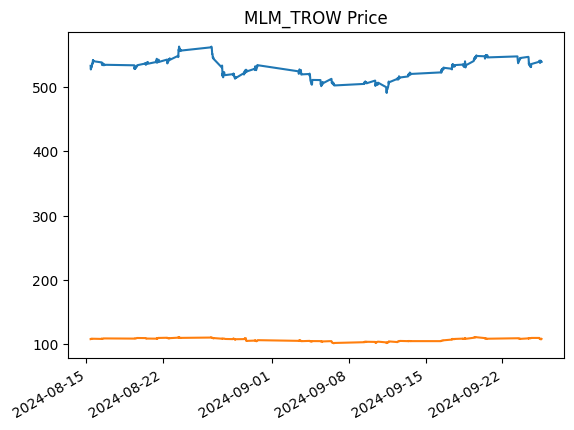

In [58]:
#两只股票的价格走势
portfolios['MLM_TROW'].close.plot(title='MLM_TROW Price',legend=False)

下图为该交易的累积收益，紫色折线表示本次交易的累积收益，深绿色折线表示基准收益，即从一开始即买入股票持有至到期的收益率。

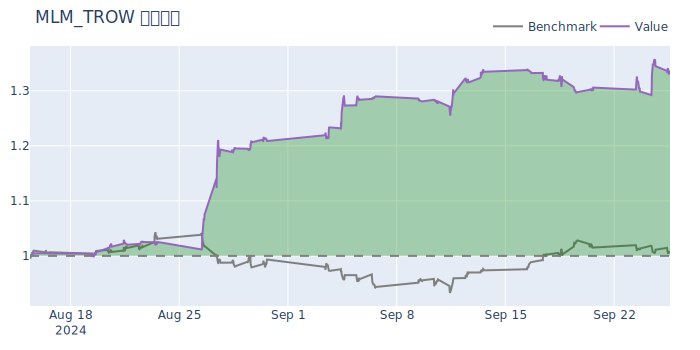

In [59]:
portfolios['MLM_TROW'].plot_cum_returns(title='MLM_TROW 累积收益').show_svg()

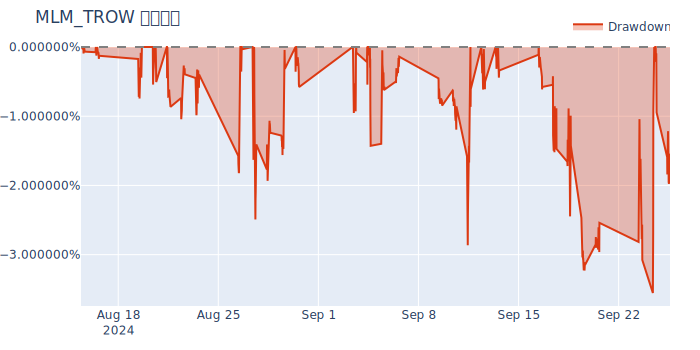

In [60]:
portfolios['MLM_TROW'].plot_underwater(title='MLM_TROW 回撤比率').show_svg()

In [61]:
from functools import partial

In [62]:
def plot_orders(portfolio,column=None,add_trace_kwargs=None,fig=None):
  portfolio.orders.plot(column=column,add_trace_kwargs=add_trace_kwargs,fig=fig)

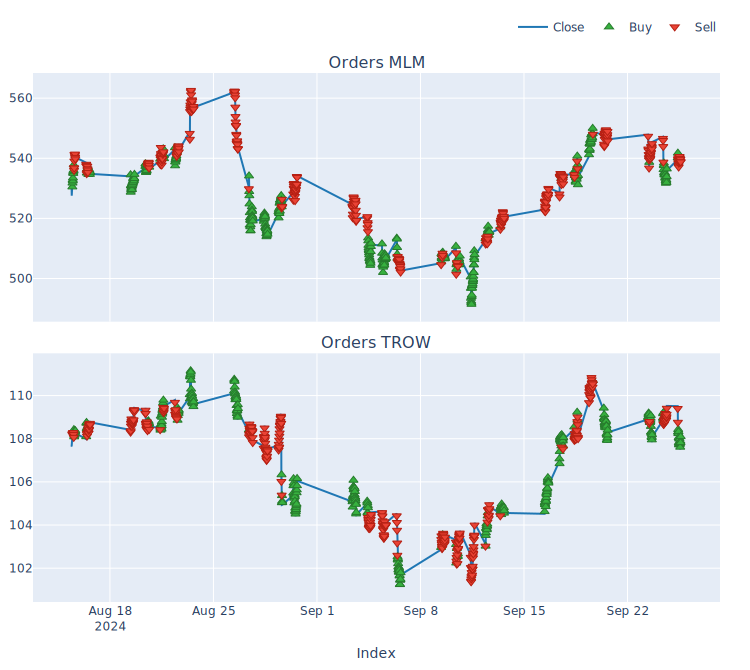

In [63]:
def plot_orders(portfolio,column=None,add_trace_kwargs=None,fig=None):
  portfolio.orders.plot(column=column,add_trace_kwargs=add_trace_kwargs,fig=fig)
portfolios['MLM_TROW'].plot(subplots=[
    ('MLM_orders',dict(
        title='Orders MLM',
        yaxis='Price',
        check_is_not_grouped=False,
        plot_func=partial(plot_orders,column=('y','y')),
        pass_column=False
    )),
     ('TROW_orders', dict(
        title='Orders TROW',
        yaxis='Price',
        check_is_not_grouped=False,
        plot_func=partial(plot_orders, column=('x','x')),
        pass_column=False
    )),
]).show_svg()

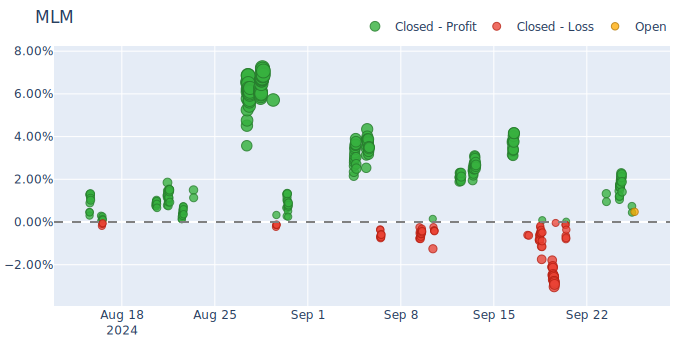

In [64]:
portfolios['MLM_TROW'].trades.plot_pnl(column=('y','y'),title='MLM').show_svg()

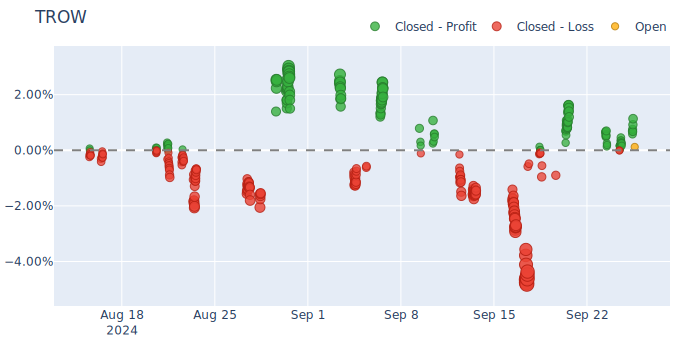

In [65]:
portfolios['MLM_TROW'].trades.plot_pnl(column=('x','x'),title='TROW').show_svg()

#总结：
通过对标普500和纳斯达克100股票的历史数据进行配对交易策略的设计与回测，以上内容展示了策略的有效性和可操作性。

* 在41天交易日回测期间，总回报率为 32.98%，远高于基准的 0.73%，展示出该策略的强大盈利能力。
* **夏普比率（Sharpe Ratio）**为 8.55，表明策略在风险调整后的收益表现优异。
* **最大回撤（Max Drawdown）**为 3.41%。
* 交易数量为 683 笔，闭合681笔，胜率为57.56%。最大亏损幅度为3.41%，最长亏损持续时间为8天，表明风险控制较好。

整个配对交易的过程仍然有很多可以提高的地方：
* 数据方面：
  * 选择比如60分钟、120分钟可能可以更好的把握时机，捕捉交易机会
  * 相关文献表明训练数据年份的长短会影响结果，可以适当延长时间区间
  * 可以尝试使用相关ETF，ETF相比个股具有更高的稳健性
* 不论使用机器学习模型还是统计分析，都存在大量参数，使用网格搜索或者贝叶斯优化等方式对相关参数进一步优化可能取得更好的结果
* 在交易策略部分，这里选择的是基本款的标准差方式，可以通过时间序列模型（ARIMA模型，LSTM模型等）对价差进行预测，从而对均值偏离程度进一步精准把控。（相关文献采用了LSTM模型对spread进行预测从而判断交易信号，可以很好的控制回撤，但是会牺牲部分利润）
* 亏损持仓时长：部分交易持仓时间比较长，拖累了整体表现，未来可以通过优化平仓策略或者使用时间止损策略（Alpha衰减模型、事件驱动止损等）。
* 与动量因子结合，当市场动量强烈时，减少开仓。通过动态调整仓位和增加风控模型来控制回撤，比如使用波动率控制和加入止损。
* 更精细的协整监控。如加入动态性，设置滑动窗口定期评估配对的协整关系，协整关系失效时及时退出头寸。或者使用更复杂的协整检验方式，如Copula。